# III. Mô hình hoá

## Import các thư viện cần thiết

In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

## Load dataset đã được preprocessed

In [353]:
df = pd.read_csv("../Data/preprocessed/cleaned_dataset.csv")
df.head()

,Company,Year,EPS ($),Earnings ($B),Revenue ($B),Marketcap ($B),Total Debts ($B),Net Assets ($B),Total Assets ($B),Cash on hand ($B),Country,Share price ($),Categories
0,Apple,2023,6.16,114.30,383.28,3043.0,111.08,62.14,352.58,61.55,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
1,Apple,2022,5.92,113.96,387.53,2066.0,120.06,50.67,352.75,48.30,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
2,Apple,2021,6.08,116.90,378.32,2901.0,124.71,63.09,351.00,62.63,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
3,Apple,2020,3.74,74.25,294.13,2255.0,112.43,65.33,323.88,90.94,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
4,Apple,2019,3.19,66.15,267.68,1287.0,108.04,90.48,338.51,100.55,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."


# Dự đoán giá trị `Cash on hand ($B)` của các công ty thuộc danh mục phần mềm ở USA

**Cách thực hiện**

...

**Mục tiêu**

...

Lấy ra các obseravtion thoả 2 điều kiện sau:

- Danh mục: `Categories` có chứa `Software`

- Địa điểm: `Country` là `USA`

In [354]:
#software_cat_mask = df["Categories"].apply(lambda x: True if "Software" in x.split(", ") else False)
software_cat_mask = df["Categories"].str.contains('Software')

usa_mask = df["Country"] == "USA"

cleaned_df = df[software_cat_mask & usa_mask].copy()
print("Shape:", cleaned_df.shape)

Shape: (1610, 13)


Bởi vì phạm vi đang xét là trên danh mục `Software` cho nên cột `Categories` không còn cần thiết nữa. Tương tự cho cột `Country`.

Bên cạnh đó, `Company` chỉ dùng để nhận diện tên của công ty cho nên cũng không quá cần thiết trong việc dự đoán nên ta sẽ drop luôn

In [355]:
cleaned_df.drop(columns=["Categories", "Country", "Company"], axis = 1,inplace=True)
cleaned_df.head()

,Year,EPS ($),Earnings ($B),Revenue ($B),Marketcap ($B),Total Debts ($B),Net Assets ($B),Total Assets ($B),Cash on hand ($B),Share price ($)
0,2023,6.16,114.30,383.28,3043.0,111.08,62.14,352.58,61.55,195.71
1,2022,5.92,113.96,387.53,2066.0,120.06,50.67,352.75,48.30,195.71
2,2021,6.08,116.90,378.32,2901.0,124.71,63.09,351.00,62.63,195.71
3,2020,3.74,74.25,294.13,2255.0,112.43,65.33,323.88,90.94,195.71
4,2019,3.19,66.15,267.68,1287.0,108.04,90.48,338.51,100.55,195.71


In [356]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1610 entries, 0 to 38087
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               1610 non-null   int64  
 1   EPS ($)            1610 non-null   float64
 2   Earnings ($B)      1610 non-null   float64
 3   Revenue ($B)       1610 non-null   float64
 4   Marketcap ($B)     1610 non-null   float64
 5   Total Debts ($B)   1610 non-null   float64
 6   Net Assets ($B)    1610 non-null   float64
 7   Total Assets ($B)  1610 non-null   float64
 8   Cash on hand ($B)  1610 non-null   float64
 9   Share price ($)    1610 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 138.4 KB


## Lựa chọn features

Gán X và y lần lượt là tập `features` và tập `target`

In [357]:
X = cleaned_df.drop(columns="Cash on hand ($B)").values
y = cleaned_df["Cash on hand ($B)"].values
X_col_names = cleaned_df.drop(columns="Cash on hand ($B)").columns
print ("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1610, 9)
y shape: (1610,)


Model `Lasso` có xu hướng sẽ kéo các `features kém quan trọng` về gần giá trị `0`. Do đó, ta sẽ sử dụng `Lasso` tìm ra các `features` phù hợp cho việc xây dựng mô hình.

Hyperparameter (`alpha`) truyền vào `Lasso` là `0.3`. Mục tiêu của ta là tìm ra features quan trọng cho mô hình nên việc chọn `alpha` tối ưu là không quá quan trọng.

[-0.02114108 -0.03687968  0.         -0.26713145  0.01795552  0.10247198
  0.37716075  0.22815576  0.00047522]


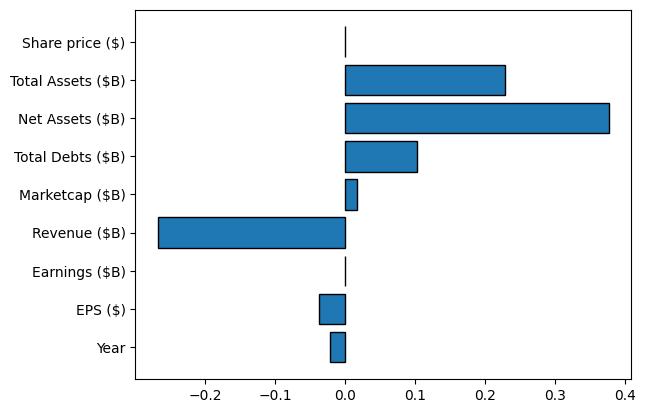

In [358]:
# Import Lasso
from sklearn.linear_model import Lasso

# Instantiate a lasso regression model
lasso = Lasso(0.3)

# Fit the model to the data
lasso.fit(X, y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)
plt.barh(X_col_names, lasso_coef, edgecolor="black")
plt.show()

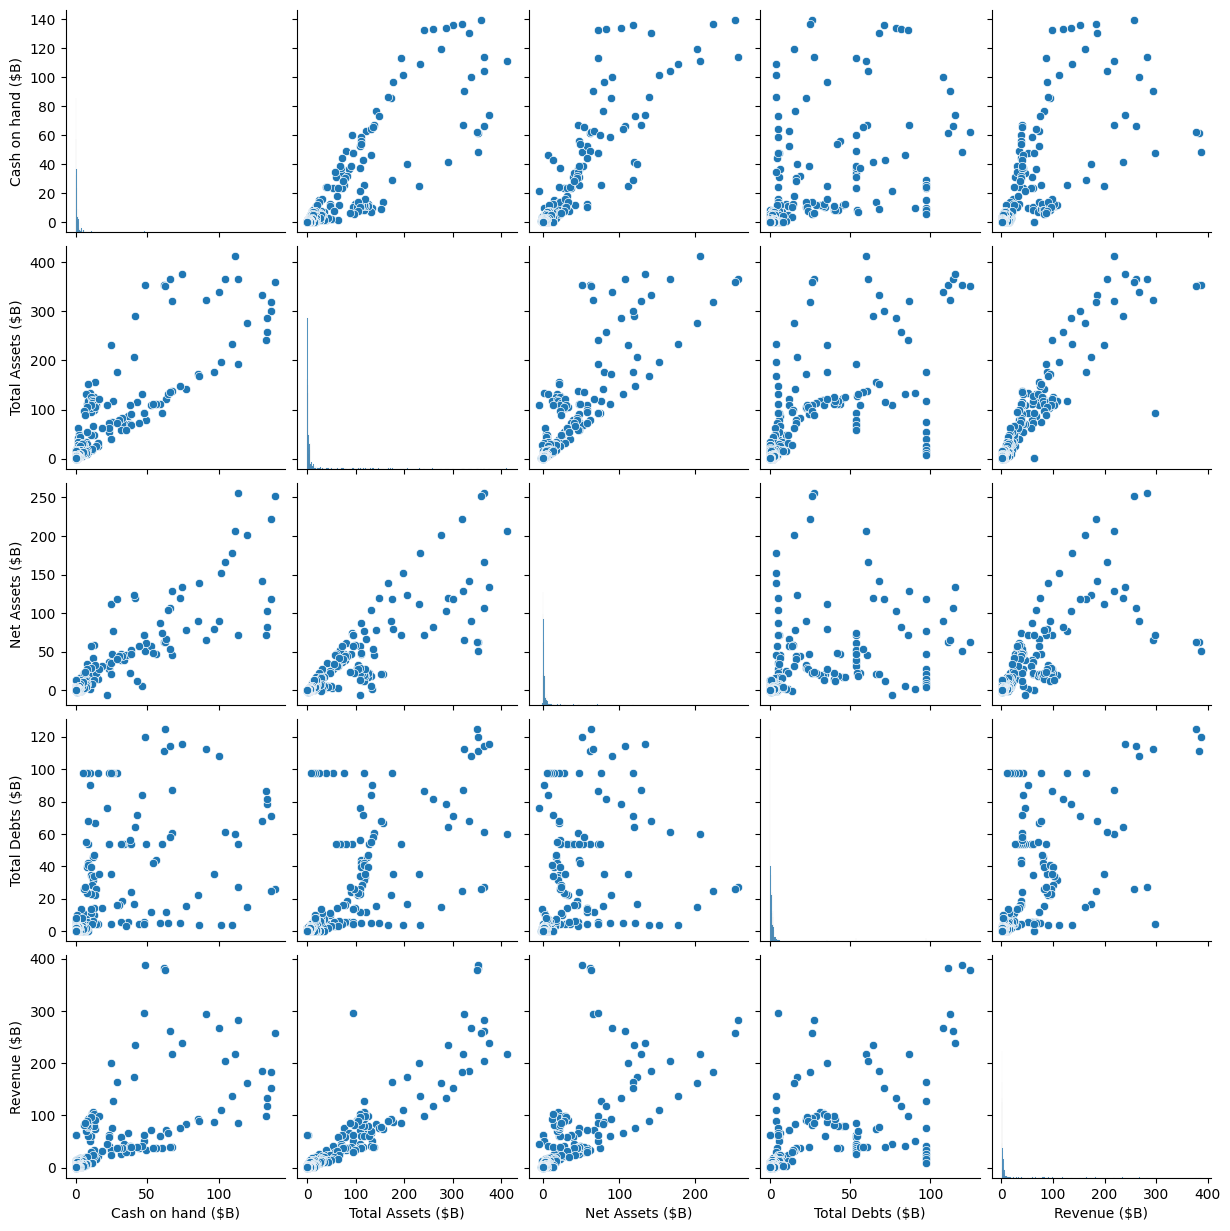

In [359]:
sns.pairplot(data=cleaned_df, vars=["Cash on hand ($B)", "Total Assets ($B)",
                "Net Assets ($B)",
                "Total Debts ($B)",
                "Revenue ($B)"])

**Nhận xét**

- Các features kém quan trọng (càng gần giá trị `0`) bao gồm: `Share price ($B)`, `Marketcap ($B)`, `Earning ($B)`, `EPS ($B)` và `Year`

- Các features còn lại ta sẽ dùng cho việc mô hình hoá

Gán lại `X` và `y`

<Axes: >

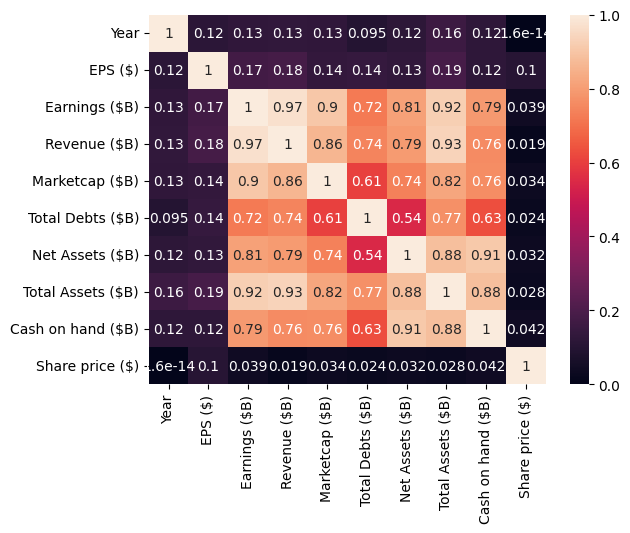

In [360]:
sns.heatmap(cleaned_df.corr(), annot=True)

In [361]:
X = cleaned_df[["Total Assets ($B)",
                "Net Assets ($B)",
                "Total Debts ($B)",
                "Revenue ($B)" ]].values

X = cleaned_df[["Earnings ($B)", "Revenue ($B)", "Marketcap ($B)", "Total Debts ($B)", "Net Assets ($B)", "Total Assets ($B)"]
].values

y = cleaned_df["Cash on hand ($B)"].values
print ("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1610, 6)
y shape: (1610,)


## Lựa chọn mô hình 

Thử fit dữ liệu với 3 model khác nhau để tìm ra model phù hợp nhất với dữ liệu hiện có.

In [362]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, make_scorer

Sử dụng `train_test_split` để chia training set và test set với train_size là 0.7

In [363]:
X_train, X_test , y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, train_size=0.7)

Sử dụng phương pháp `k-fold cross-validation` (5-folds) để đánh giá hiệu suất của các mô hình

0.8792428644925477
0.8792428647729678
0.8792438393778934


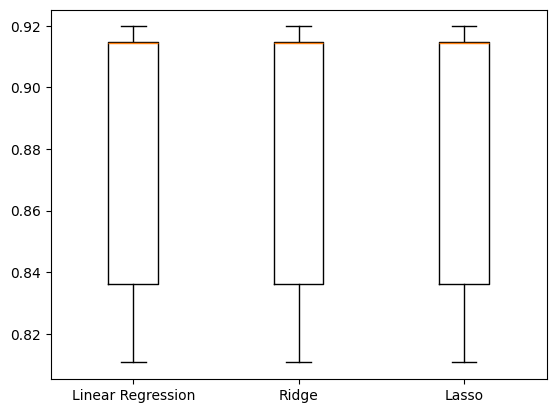

In [364]:
models = {"Linear Regression": LinearRegression(),
          "Ridge": Ridge(alpha=0.001),
          "Lasso": Lasso(alpha=0.001)}
results = []


# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X, y, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
for res in results:
    print(res.mean())
plt.boxplot(results, labels=models.keys())
plt.show()

In [365]:
models = {"Linear Regression": LinearRegression(),
          "Ridge": Ridge(alpha=0.001),
          "Lasso": Lasso(alpha=0.001)}
results = []


# Loop through the models' values
for model in models.values():
  model.fit(X_train, y_train)
  
  # Append the results
  results.append(model.score(X_test, y_test))

# Create a box plot of the results
for res in results:
    print(res)


0.8622461858678905
0.862246187264084
0.8622516777751699


Nhìn chung thì cả 3 models đều cho ra hiệu suất gần như nhau. Tuy nhiên thì Lasso vẫn cao hơn nhưng không đáng kể. Do vậy ta chọn Lasso

# Training Lasso

In [366]:
model = Lasso(alpha= 0.1)

model.fit(X_train, y_train)
score = model.score(X_test, y_test)
score

0.8627863752146936

# Hyperparamater tuning

In [367]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

lasso = Lasso()

# Set up the parameter grid
param_grid = {"alpha": np.linspace(0.0001, 1, 100)}

# Instantiate lasso_cv

kf = KFold(n_splits=5, random_state=42, shuffle=True)

lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)

# Fit to the training data
lasso_cv.fit(X_train, y_train)
print("Tuned lasso paramaters: {}".format(lasso_cv.best_params_))
print("Tuned lasso score: {}".format(lasso_cv.best_score_))

Tuned lasso paramaters: {'alpha': 1.0}
Tuned lasso score: 0.8785314729976174


## Scaling dữ liệu

Bởi vì các regression models mà ta sử dụng (`Linear Regression`, `Lasso` và `Ridge`) thường bị tác động bởi `Scaling`, do đó `Scaling` trước khi training cũng có thể cải thiện hiệu suất của mô hình.

**Lưu ý**: cần chia training set và test set trước khi scaling. Bởi vì khi áp dụng `StandardScaler`, ta muốn giá trị `mean` và `std` chỉ được tính dựa trên training set chứ không phải toàn bộ data hiện có.

In [368]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


pipe = make_pipeline(StandardScaler(), Lasso(alpha = 0.1))


pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.869116292948941

## Đánh giá